## PRÁCTICA AUDIO
#### MIREN OSTOLAZA Y MARÍA GARCÍA

El objetivo de esta práctica será analizar diferentes audios que pertenecen a 7 clases diferentes haciendo referencia cada  una a una emoción humana:
  * Angry
  * Disgusted
  * Fearful
  * Happy
  * Neutral
  * Sad
  * Surprised
  
Una vez se ha realizado un análisis del dataset, se generará un modelo de clasificación con el fin de relacionar un audio a la emoción que se pueda detectar del mismo.

In [2]:
import librosa
from librosa import display
import os
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import IPython 
from IPython.display import display

from tqdm import tqdm
from matplotlib import cm, colors, pyplot as plt
from matplotlib.colors import ListedColormap
import librosa 
import librosa.display
import random

import tensorflow as tf
import tensorflow.python.keras as k

from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [3]:
path = './Emotions'
lst = []
i = -2
start_time = time.time()

for subdir, dirs, files in os.walk(path):
  i=i+1
  print(subdir)
  print(i)
  for file in files:

        #Load librosa array, obtain mfcss, add them to array and then to list.
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_fft=4096, hop_length=256, n_mfcc=40).T,axis=0) 
        arr = mfccs, i
        lst.append(arr) #Here we append the MFCCs to our list.

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

./Emotions
-1
./Emotions\Angry
0
./Emotions\Disgusted
1
./Emotions\Fearful
2
./Emotions\Happy
3
./Emotions\Neutral
4
./Emotions\Sad
5
./Emotions\Suprised
6
--- Data loaded. Loading time: 985.3068246841431 seconds ---


# VISUALIZATION OF AUDIO

Para obtener más información sobre los audios que se van a analizar, se visualizan dichos audios de forma gráfica para poder plasmar sus caracteristicas como la amplitud,la frecuencia o el timbre. Como el dataset con el que se trabajará consta de varios audios pertenecientes a diferentes clases, se ha seleccionado un audio por cada clase o emoción para poder analizar mejor las diferencias entre ellos. 

In [10]:
import librosa
angry = './Emotions/Angry/03-01-05-01-01-01-02.wav'
disgusted = './Emotions/Disgusted/03-01-07-01-01-01-01.wav'
fearful = './Emotions/Fearful/03-01-06-01-01-01-01.wav'
happy = './Emotions/Happy/03-01-03-01-01-01-01.wav'
neutral = './Emotions/Neutral/03-01-01-01-01-01-02.wav'
sad = './Emotions/Sad/03-01-04-01-01-01-01.wav'
suprised = './Emotions/Suprised/03-01-08-01-01-01-01.wav'



x_angry , sr_angry = librosa.load(angry,sr=22050)
x_disgusted , sr_disgusted = librosa.load(disgusted)
x_fearful , sr_fearful = librosa.load(fearful)
x_happy , sr_happy = librosa.load(happy)
x_neutral , sr_neutral = librosa.load(neutral)
x_sad , sr_sad = librosa.load(sad)
x_suprised , sr_suprised = librosa.load(suprised)


 Todos los audios se componene de la misma frase con connotaciones diferentes respecto a la entonación de forma que simulan diferentes estados de ánimo.A continuación se reproduce el audio seleccionado de la clase angry como ejemplo y para escuchar la frase que se repite en cada audio:

In [6]:
def play_signal(x, sr):
    return IPython.display.Audio(data = x, rate = sr)

play_signal(x_angry, sr_angry)


## Waveform

El sonido son vibraciones, pequeñas ondas de presión en el aire. Para representar esas ondas y su amplitud a continuación se muestran los gráficos llamados 'waveform' de la amplitud de una forma de onda por cada emoción.

Text(0.5, 1.0, 'Suprised')

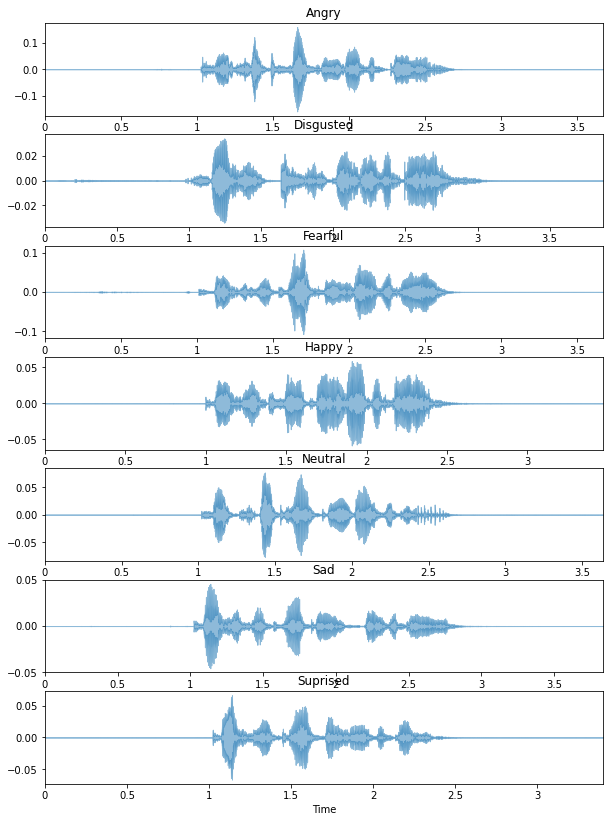

In [7]:
%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import librosa.display


plt.figure(figsize=(10, 14))
plt.subplot(7, 1, 1)
librosa.display.waveplot(x_angry, sr=sr_angry,alpha=0.5)
plt.title('Angry')
plt.subplot(7, 1, 2)
librosa.display.waveplot(x_disgusted, sr=sr_disgusted,alpha=0.5)
plt.title('Disgusted')
plt.subplot(7, 1, 3)
librosa.display.waveplot(x_fearful, sr=sr_fearful,alpha=0.5)
plt.title('Fearful')
plt.subplot(7, 1, 4)
librosa.display.waveplot(x_happy, sr=sr_happy,alpha=0.5)
plt.title('Happy')
plt.subplot(7, 1, 5)
librosa.display.waveplot(x_neutral, sr=sr_neutral,alpha=0.5)
plt.title('Neutral')
plt.subplot(7, 1, 6)
librosa.display.waveplot(x_sad, sr=sr_sad,alpha=0.5)
plt.title('Sad')
plt.subplot(7, 1, 7)
librosa.display.waveplot(x_suprised, sr=sr_suprised,alpha=0.5)
plt.title('Suprised')


Una vez se han representado los waveforms de cada clase del dataset se pueden apreciar ciertas diferencias y similitudes entre ellas. Por ejemplo, vemos que el audio de angry y disgusted son diferentes en cuanto sobre todo al inicio del audio. Sin embargo, podría decirse que angry y fearful comparten cierta similitud en cuanto a sample rate, así como sad y surprise. Por otro lado, también se puede apreciar que en todos os audios hay silencios al inicio y al final.

## Spectrum analysis

Lo siguiente será  conocer en mayor profundidad las frecuencias presentes en las grabaciones de audio que se están analizando. Para ello, lo primero será aplicar la transformada de Fourier tal y como se muestra a continuación. La transformada de Fourier con una señal es capaz de calcular qué frecuencias están presentes en ella. Es decir, convierte una señal en el dominio del tiempo a un dominio de la frecuencia.

Text(0.5, 1.0, 'Power spectrum of surprised')

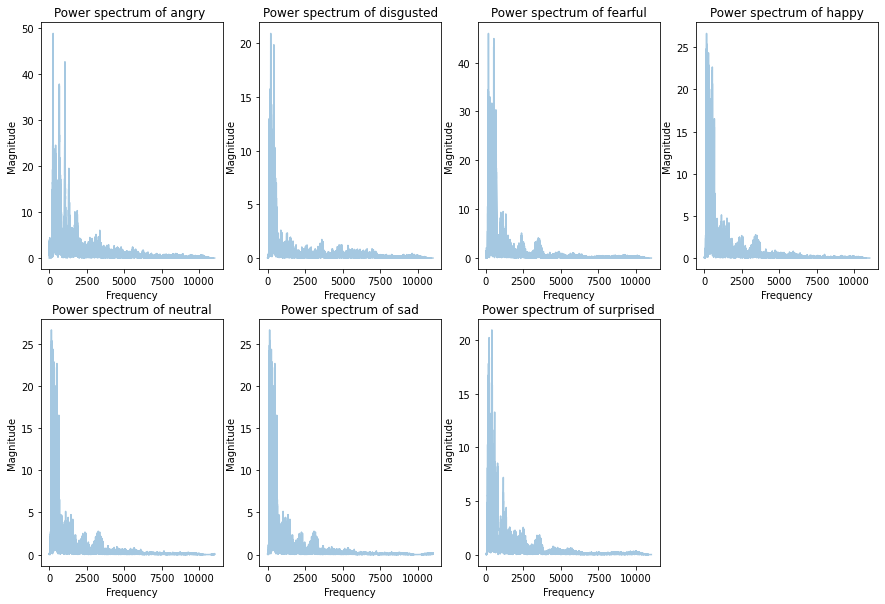

In [8]:

# Fourier transform

ff_angry =np.fft.fft(x_angry)
ff_disgusted = np.fft.fft(x_disgusted)
ff_fearful = np.fft.fft(x_fearful)
ff_happy = np.fft.fft(x_happy)
ff_neutral = np.fft.fft(x_neutral)
ff_sad = np.fft.fft(x_sad)
ff_suprised = np.fft.fft(x_suprised)

spectrum1 = np.abs(ff_angry)
spectrum2 = np.abs(ff_disgusted)
spectrum3 = np.abs(ff_fearful)
spectrum4 = np.abs(ff_happy)
spectrum5 = np.abs(ff_neutral)
spectrum6 = np.abs(ff_sad)
spectrum7 = np.abs(ff_suprised)

# Genera variable de frecuencia
f1 = np.linspace(0, sr_angry, len(spectrum1))
f2 = np.linspace(0, sr_disgusted, len(spectrum2))
f3 = np.linspace(0, sr_fearful, len(spectrum3))
f4 = np.linspace(0, sr_happy, len(spectrum4))
f5 = np.linspace(0, sr_neutral, len(spectrum5))
f6 = np.linspace(0, sr_sad, len(spectrum6))
f7 = np.linspace(0, sr_suprised, len(spectrum7))


left_spectrum1 = spectrum1[:int(len(spectrum1)/2)]
left_f1 = f1[:int(len(spectrum1)/2)]

left_spectrum2 = spectrum2[:int(len(spectrum2)/2)]
left_f2 = f2[:int(len(spectrum2)/2)]

left_spectrum3 = spectrum3[:int(len(spectrum3)/2)]
left_f3 = f3[:int(len(spectrum3)/2)]

left_spectrum4 = spectrum4[:int(len(spectrum4)/2)]
left_f4 = f4[:int(len(spectrum4)/2)]

left_spectrum5 = spectrum4[:int(len(spectrum5)/2)]
left_f5 = f5[:int(len(spectrum5)/2)]

left_spectrum6 = spectrum4[:int(len(spectrum6)/2)]
left_f6 = f6[:int(len(spectrum6)/2)]

left_spectrum7 = spectrum7[:int(len(spectrum7)/2)]
left_f7 = f7[:int(len(spectrum7)/2)]

fig = plt.figure(figsize=(15,10))
plt.subplot(2, 4, 1)

plt.plot(left_f1, left_spectrum1, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of angry ")

plt.subplot(2, 4,2)

plt.plot(left_f2, left_spectrum2, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of disgusted")
 
plt.subplot(2, 4, 3)
plt.plot(left_f3, left_spectrum3, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of fearful")

plt.subplot(2, 4, 4)
plt.plot(left_f4, left_spectrum4, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of happy")

plt.subplot(2, 4, 5)
plt.plot(left_f5, left_spectrum5, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of neutral")

plt.subplot(2, 4, 6)
plt.plot(left_f6, left_spectrum6, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of sad")

plt.subplot(2, 4, 7)
plt.plot(left_f7, left_spectrum7, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum of surprised")

Ahora que se puede ver más facil las amplitudes y las diferentes ondas, se observa que el mayor numero de ondas que se diferencian en el caso de angry.
Por otra parte, el audio de happy y sad parecen ser parecidos según este análisis spectrum aunque pueda parecer contradictorio.

## Spectogram

Para terminar con la parte de visualización de los audios  y continuando con los la transformada de Fourier, se representan los espectogramas de los audios seleccionados. Un espectograma es la representación visual del espectro de frecuencias de una señal al variar con el tiempo, presentando la evolución de la señal en el dominio tiempo-frecuencia.

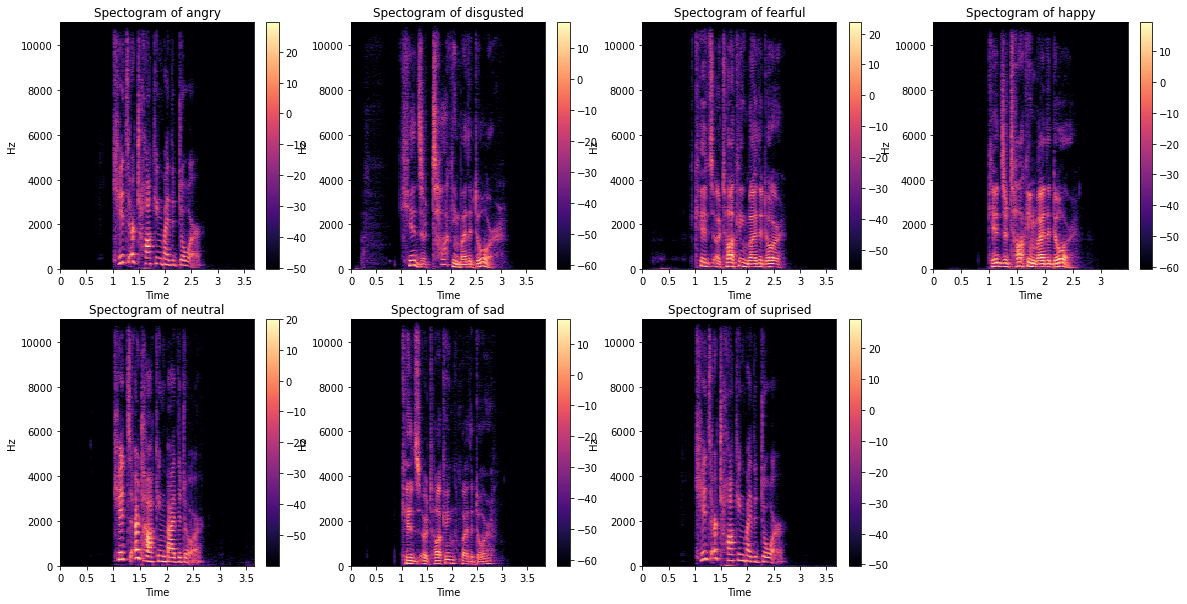

In [9]:

X_angry = librosa.stft(x_angry)
X_disgusted = librosa.stft(x_disgusted)
X_fearful= librosa.stft(x_fearful)
X_happy = librosa.stft(x_happy)
X_neutral = librosa.stft(x_neutral)
X_sad = librosa.stft(x_sad)
X_suprised = librosa.stft(x_suprised)



Xdb1 = librosa.amplitude_to_db(abs(X_angry))
Xdb2= librosa.amplitude_to_db(abs(X_disgusted))
Xdb3 = librosa.amplitude_to_db(abs(X_fearful))
Xdb4 = librosa.amplitude_to_db(abs(X_happy))
Xdb5 = librosa.amplitude_to_db(abs(X_neutral))
Xdb6 = librosa.amplitude_to_db(abs(X_sad))
Xdb7 = librosa.amplitude_to_db(abs(X_suprised))


plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
librosa.display.specshow(data=Xdb1, sr=sr_angry, x_axis='time', y_axis='hz')
plt.title("Spectogram of angry")
plt.colorbar()

plt.subplot(2, 4, 2)
librosa.display.specshow(data=Xdb2, sr=sr_disgusted, x_axis='time', y_axis='hz')
plt.title("Spectogram of disgusted")
plt.colorbar()

plt.subplot(2, 4, 3)
librosa.display.specshow(data=Xdb3, sr=sr_fearful, x_axis='time', y_axis='hz')
plt.title("Spectogram of fearful")
plt.colorbar()

plt.subplot(2, 4, 4)
librosa.display.specshow(data=Xdb4, sr=sr_happy, x_axis='time', y_axis='hz')
plt.title("Spectogram of happy")
plt.colorbar()

plt.subplot(2, 4, 5)
librosa.display.specshow(data=Xdb5, sr=sr_neutral, x_axis='time', y_axis='hz')
plt.title("Spectogram of neutral")
plt.colorbar()

plt.subplot(2, 4, 6)
librosa.display.specshow(data=Xdb6, sr=sr_sad, x_axis='time', y_axis='hz')
plt.title("Spectogram of sad")
plt.colorbar()

plt.subplot(2, 4, 7)
librosa.display.specshow(data=Xdb1, sr=sr_suprised, x_axis='time', y_axis='hz')
plt.title("Spectogram of suprised")
plt.colorbar()

Estas gráficas nos permiten ver mejor las frecuencias presentes en los audios. El eje vertical muestra las diferentes frecuencias ( de 0 a 10kHz) y el eje horizontal muestra el tiempo. Los diferentes colores representan el nivel en el dominio del tiempo y de frecuencia.
En este caso, parece que esa relación se da de manera más intensa en el caso de angry, fearful, neutral y surprised.

# Feature extraction

El siguiente paso será el la extraccion de features previa a la clasificación de ls audios. Para ello, se han definido varias funciones que utilizan diferentes métodos para obtener más información sobre los audios de cada clase de emoción:
   * PCEN
   * Spectral centroids
   * Spectral rolloff
   * Melspectrogram
   * Spectral bandwidth
   * Chromagram
   * MFCC


In [11]:

def PCEN(x, sr):
    s = librosa.feature.melspectrogram(x, 
                                   sr         = sr,
                                   n_mels     = 128,
                                   hop_length = 512,
                                   n_fft      = 2048,
                                   fmin       = 20,
                                   fmax       = sr//2)
 

    pcen_librosa = librosa.core.pcen(s, 
                                 sr            = sr,
                                 hop_length    = 512,
                                 gain          = 0.6,
                                 bias          = 0.1,
                                 power         = 0.2,
                                 time_constant = 0.4,
                                 eps           = 1e-9)
  
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(pcen_librosa, sr=sr, x_axis='time')
    plt.title("PCEN")
    plt.colorbar() 

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def spectral_centroids(x, sr):
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
  
  
    plt.figure(figsize=(5, 5))
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)

    librosa.display.waveplot(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.title("Spectral centroids")
    
def spectral_rolloff(x, sr):
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr ,roll_percent=0.99)[0]
  
    plt.figure(figsize=(5, 5))
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveplot(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.title("Spectral rolloff")

def melspectrogram(x, sr):
    mel = librosa.feature.melspectrogram(x, sr = sr, n_mels=128, fmin=20, fmax=sr//2)
  
  
    plt.figure(figsize=(5, 5))
    
    librosa.display.specshow(mel, sr=sr, x_axis='time')
    plt.xlabel("time")
    plt.colorbar()
    plt.title("Melspectrogram")
def spectral_bandwidth(x, sr):
    spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.00001, sr=sr)[0]
    spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.00001, sr=sr, p=3)[0]
    spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.00001, sr=sr, p=4)[0]
    frames = range(len(spectral_bandwidth_2))
    t = librosa.frames_to_time(frames)
  
    plt.figure(figsize=(5, 5))
    librosa.display.waveplot(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_bandwidth_2), color='r')
    plt.plot(t, normalize(spectral_bandwidth_3), color='g')
    plt.plot(t, normalize(spectral_bandwidth_4), color='y')
    plt.title("Spectral bandwidth")
    plt.legend(('p = 2', 'p = 3', 'p = 4'))
    
def chromagram(x, sr):
    hop_length = 512
    chromagram = librosa.feature.chroma_stft(x, sr =sr, hop_length=hop_length)
  
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    plt.title("Chromagram")
    plt.colorbar()
    
    
def MFCC(x,sr):
    mfccs = librosa.feature.mfcc(x, sr=sr)
    plt.figure(figsize=(5, 5))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.title("MFCC")

Una vez se tienen definidas las funciones, se procede a analizar el caso de cada audio:

### Happy

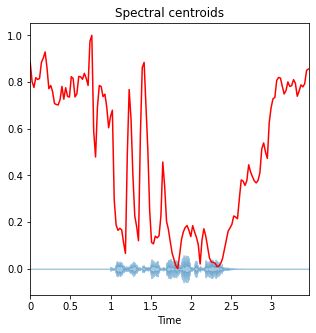

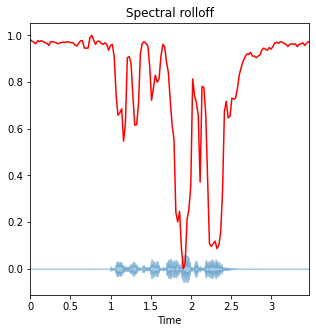

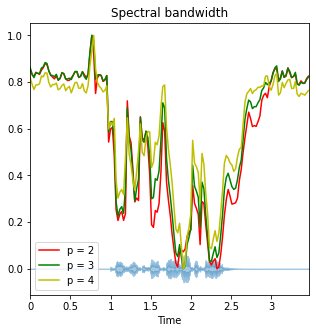

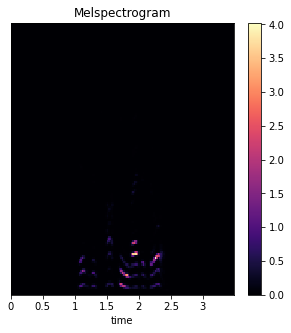

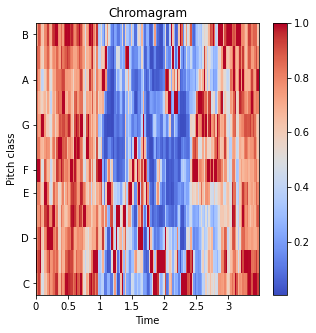

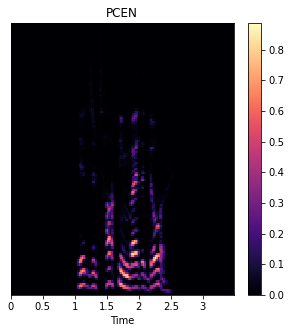

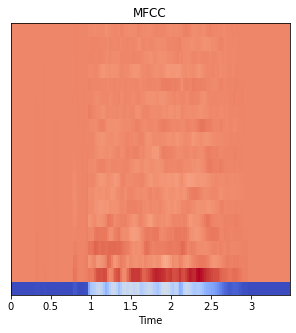

In [12]:
normalize(x_happy)
spectral_centroids(x_happy, sr_happy)
spectral_rolloff(x_happy, sr_happy)
spectral_bandwidth(x_happy, sr_happy)
melspectrogram(x_happy, sr_happy)
chromagram(x_happy, sr_happy)
PCEN(x_happy, sr_happy)
MFCC(x_happy,sr_happy)


### Sad

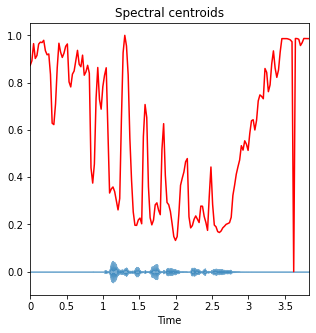

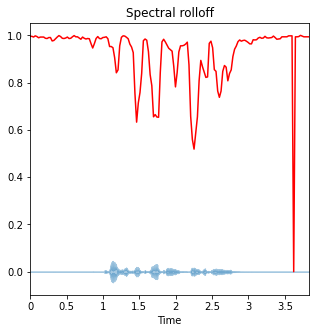

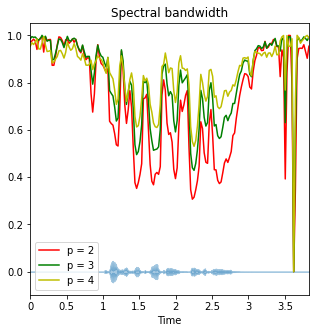

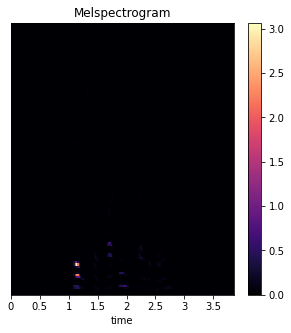

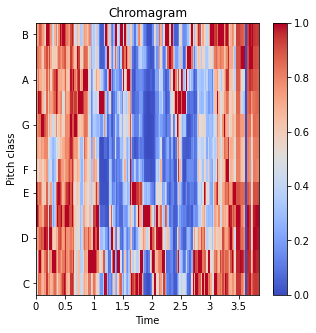

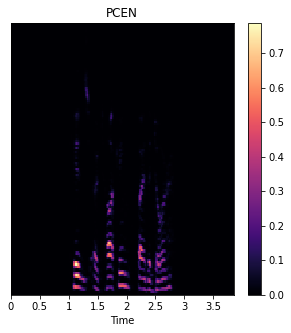

In [24]:
spectral_centroids(x_sad, sr_sad)
spectral_rolloff(x_sad, sr_sad)
spectral_bandwidth(x_sad, sr_sad)
melspectrogram(x_sad, sr_sad)
chromagram(x_sad, sr_sad)
PCEN(x_sad, sr_sad)
play_signal(x_sad, sr_sad)

Se puede ver que en los audios hay segundos de silencio al principio y al final. Para por analizar mejor las features de las diferentes clases se ha decidido eliminar los segundos de silencio con la función que se presenta a continuación:

In [55]:
from pydub import AudioSegment


def removal(files_path,file_name):
    startSec = 1


    endSec = 3

    # Time to miliseconds
    startTime = startSec*1000
    endTime = endSec*1000

    # Opening file and extracting segment
    song = AudioSegment.from_mp3( files_path+file_name+'.wav' )
    extract = song[startTime:endTime]

    # Saving
    extract.export( file_name+'-extract.wav', format="wav")



In [56]:

removal('./Emotions/Angry/','03-01-05-01-01-01-02')
x_angry2 , sr_angry2 = librosa.load('03-01-05-01-01-01-02-extract.wav',sr=22050)
play_signal(x_angry2, sr_angry2)

Una vez hemos conseguido eliminar los slencios se vuelven a extraer lso features en este caso de un audio perteneciente a la clase angry.

### Angry

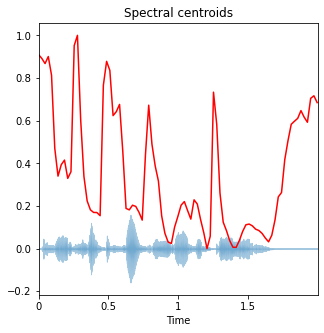

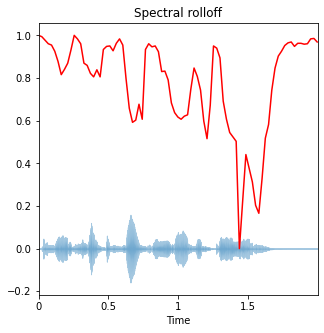

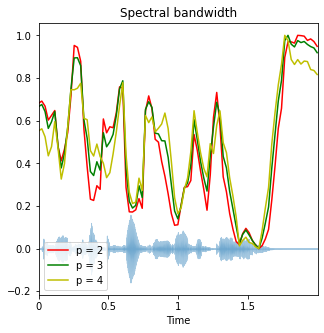

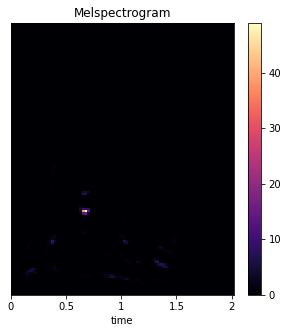

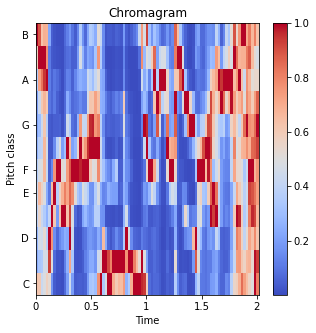

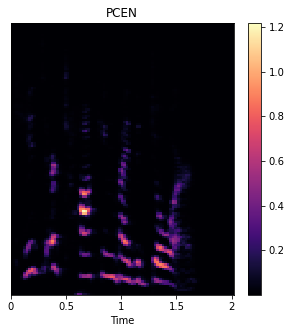

In [59]:
normalize(x_angry2)
spectral_centroids(x_angry2, sr_angry2)
spectral_rolloff(x_angry2, sr_angry2)
spectral_bandwidth(x_angry2, sr_angry2)
melspectrogram(x_angry2, sr_angry2)
chromagram(x_angry2, sr_angry2)
PCEN(x_angry2, sr_angry2)

### CLASSIFICATION

In [17]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)
import numpy as np
X = np.asarray(X)
y = np.asarray(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#As always we need to expand the dimensions, so we can input the data to NN.
x_traincnn = np.expand_dims(X_train, axis=2) 
x_testcnn = np.expand_dims(X_test, axis=2)

In [17]:
#pip install keras

In [18]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [19]:
#Simple model

model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(40, 1)),

        # 1st dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)),
        keras.layers.Dropout(0.5),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dropout(0.5),

        # 3rd dense layer
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # output layer
        keras.layers.Dense(10, activation='softmax')
    ])

    # compile model
optimiser = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [20]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=100, epochs=3000, validation_data=(x_testcnn, y_test))

Epoch 1/3000
116/116 [==============================] - 2s 9ms/step - loss: 76.0337 - accuracy: 0.1399 - val_loss: 38.3831 - val_accuracy: 0.1734
Epoch 2/3000
116/116 [==============================] - 0s 4ms/step - loss: 59.0823 - accuracy: 0.1320 - val_loss: 22.7863 - val_accuracy: 0.1641
Epoch 3/3000
116/116 [==============================] - 0s 4ms/step - loss: 50.7705 - accuracy: 0.1407 - val_loss: 16.1048 - val_accuracy: 0.1633
Epoch 4/3000
116/116 [==============================] - 0s 3ms/step - loss: 45.1850 - accuracy: 0.1453 - val_loss: 14.7713 - val_accuracy: 0.1625
Epoch 5/3000
116/116 [==============================] - 0s 3ms/step - loss: 42.8542 - accuracy: 0.1481 - val_loss: 15.0974 - val_accuracy: 0.1648
Epoch 6/3000
116/116 [==============================] - 0s 3ms/step - loss: 40.0952 - accuracy: 0.1474 - val_loss: 15.1223 - val_accuracy: 0.1617
Epoch 7/3000
116/116 [==============================] - 0s 3ms/step - loss: 37.9166 - accuracy: 0.1444 - val_loss: 14.6165 -

116/116 [==============================] - 1s 7ms/step - loss: 8.8239 - accuracy: 0.1517 - val_loss: 6.8088 - val_accuracy: 0.1727
Epoch 58/3000
116/116 [==============================] - 1s 11ms/step - loss: 8.6286 - accuracy: 0.1490 - val_loss: 6.7445 - val_accuracy: 0.1727
Epoch 59/3000
116/116 [==============================] - 1s 12ms/step - loss: 8.4507 - accuracy: 0.1594 - val_loss: 6.6808 - val_accuracy: 0.1727
Epoch 60/3000
116/116 [==============================] - 1s 11ms/step - loss: 8.3223 - accuracy: 0.1609 - val_loss: 6.6167 - val_accuracy: 0.1727
Epoch 61/3000
116/116 [==============================] - 1s 8ms/step - loss: 8.2280 - accuracy: 0.1544 - val_loss: 6.5542 - val_accuracy: 0.1727
Epoch 62/3000
116/116 [==============================] - 1s 6ms/step - loss: 8.0957 - accuracy: 0.1545 - val_loss: 6.4945 - val_accuracy: 0.1727
Epoch 63/3000
116/116 [==============================] - 1s 5ms/step - loss: 7.9650 - accuracy: 0.1567 - val_loss: 6.4329 - val_accuracy: 0.1

116/116 [==============================] - 1s 6ms/step - loss: 3.0726 - accuracy: 0.1861 - val_loss: 2.9842 - val_accuracy: 0.2242
Epoch 169/3000
116/116 [==============================] - 1s 8ms/step - loss: 3.0671 - accuracy: 0.1857 - val_loss: 2.9716 - val_accuracy: 0.2281
Epoch 170/3000
116/116 [==============================] - 1s 9ms/step - loss: 3.0448 - accuracy: 0.1984 - val_loss: 2.9594 - val_accuracy: 0.2281
Epoch 171/3000
116/116 [==============================] - 1s 8ms/step - loss: 3.0507 - accuracy: 0.1766 - val_loss: 2.9473 - val_accuracy: 0.2273
Epoch 172/3000
116/116 [==============================] - 1s 10ms/step - loss: 3.0285 - accuracy: 0.1855 - val_loss: 2.9346 - val_accuracy: 0.2297
Epoch 173/3000
116/116 [==============================] - 1s 9ms/step - loss: 3.0177 - accuracy: 0.1854 - val_loss: 2.9236 - val_accuracy: 0.2305
Epoch 174/3000
116/116 [==============================] - 1s 8ms/step - loss: 3.0005 - accuracy: 0.1917 - val_loss: 2.9116 - val_accuracy:

116/116 [==============================] - 1s 6ms/step - loss: 2.2319 - accuracy: 0.2308 - val_loss: 2.1904 - val_accuracy: 0.2961
Epoch 281/3000
116/116 [==============================] - ETA: 0s - loss: 2.2267 - accuracy: 0.23 - 1s 7ms/step - loss: 2.2266 - accuracy: 0.2300 - val_loss: 2.1863 - val_accuracy: 0.2969
Epoch 282/3000
116/116 [==============================] - 1s 7ms/step - loss: 2.2141 - accuracy: 0.2392 - val_loss: 2.1815 - val_accuracy: 0.2930
Epoch 283/3000
116/116 [==============================] - 1s 6ms/step - loss: 2.2112 - accuracy: 0.2342 - val_loss: 2.1783 - val_accuracy: 0.3000
Epoch 284/3000
116/116 [==============================] - 1s 6ms/step - loss: 2.2102 - accuracy: 0.2281 - val_loss: 2.1732 - val_accuracy: 0.2937
Epoch 285/3000
116/116 [==============================] - 1s 6ms/step - loss: 2.2191 - accuracy: 0.2288 - val_loss: 2.1701 - val_accuracy: 0.2977
Epoch 286/3000
116/116 [==============================] - 1s 6ms/step - loss: 2.2030 - accuracy: 

Epoch 336/3000
116/116 [==============================] - 1s 6ms/step - loss: 2.0445 - accuracy: 0.2592 - val_loss: 2.0039 - val_accuracy: 0.2969
Epoch 337/3000
116/116 [==============================] - 1s 6ms/step - loss: 2.0330 - accuracy: 0.2707 - val_loss: 2.0014 - val_accuracy: 0.2930
Epoch 338/3000
116/116 [==============================] - 1s 6ms/step - loss: 2.0272 - accuracy: 0.2639 - val_loss: 1.9983 - val_accuracy: 0.2930
Epoch 339/3000
116/116 [==============================] - 1s 6ms/step - loss: 2.0336 - accuracy: 0.2611 - val_loss: 1.9958 - val_accuracy: 0.2914
Epoch 340/3000
116/116 [==============================] - 1s 5ms/step - loss: 2.0323 - accuracy: 0.2590 - val_loss: 1.9926 - val_accuracy: 0.2914
Epoch 341/3000
116/116 [==============================] - 1s 6ms/step - loss: 2.0286 - accuracy: 0.2599 - val_loss: 1.9913 - val_accuracy: 0.2898
Epoch 342/3000
116/116 [==============================] - 1s 6ms/step - loss: 2.0182 - accuracy: 0.2681 - val_loss: 1.9888 -

116/116 [==============================] - 1s 6ms/step - loss: 1.7991 - accuracy: 0.3013 - val_loss: 1.7580 - val_accuracy: 0.3070
Epoch 449/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.7931 - accuracy: 0.3097 - val_loss: 1.7558 - val_accuracy: 0.3078
Epoch 450/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.7956 - accuracy: 0.3033 - val_loss: 1.7537 - val_accuracy: 0.3086
Epoch 451/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.8008 - accuracy: 0.3018 - val_loss: 1.7527 - val_accuracy: 0.3078
Epoch 452/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.7874 - accuracy: 0.3137 - val_loss: 1.7515 - val_accuracy: 0.3055
Epoch 453/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.7972 - accuracy: 0.2993 - val_loss: 1.7512 - val_accuracy: 0.3109
Epoch 454/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.7999 - accuracy: 0.3011 - val_loss: 1.7494 - val_accuracy: 

116/116 [==============================] - 1s 6ms/step - loss: 1.5629 - accuracy: 0.4214 - val_loss: 1.5144 - val_accuracy: 0.4391
Epoch 561/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.5589 - accuracy: 0.4250 - val_loss: 1.5112 - val_accuracy: 0.4383
Epoch 562/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.5558 - accuracy: 0.4239 - val_loss: 1.5104 - val_accuracy: 0.4445
Epoch 563/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.5698 - accuracy: 0.4155 - val_loss: 1.5095 - val_accuracy: 0.4445
Epoch 564/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.5419 - accuracy: 0.4339 - val_loss: 1.5100 - val_accuracy: 0.4437
Epoch 565/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.5581 - accuracy: 0.4289 - val_loss: 1.5082 - val_accuracy: 0.4492
Epoch 566/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.5576 - accuracy: 0.4221 - val_loss: 1.5052 - val_accuracy: 

116/116 [==============================] - 1s 6ms/step - loss: 1.4525 - accuracy: 0.4663 - val_loss: 1.4076 - val_accuracy: 0.4898
Epoch 673/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.4500 - accuracy: 0.4725 - val_loss: 1.4057 - val_accuracy: 0.4883
Epoch 674/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.4467 - accuracy: 0.4690 - val_loss: 1.4077 - val_accuracy: 0.4914
Epoch 675/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.4470 - accuracy: 0.4662 - val_loss: 1.4050 - val_accuracy: 0.4914
Epoch 676/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.4390 - accuracy: 0.4699 - val_loss: 1.4058 - val_accuracy: 0.4922
Epoch 677/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.4349 - accuracy: 0.4708 - val_loss: 1.4048 - val_accuracy: 0.4898
Epoch 678/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.4418 - accuracy: 0.4712 - val_loss: 1.4028 - val_accuracy: 

116/116 [==============================] - 1s 6ms/step - loss: 1.3549 - accuracy: 0.5093 - val_loss: 1.3423 - val_accuracy: 0.5156
Epoch 785/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.3614 - accuracy: 0.5107 - val_loss: 1.3389 - val_accuracy: 0.5125
Epoch 786/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.3590 - accuracy: 0.5088 - val_loss: 1.3389 - val_accuracy: 0.5148
Epoch 787/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.3688 - accuracy: 0.5023 - val_loss: 1.3385 - val_accuracy: 0.5148
Epoch 788/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.3881 - accuracy: 0.4901 - val_loss: 1.3365 - val_accuracy: 0.5211
Epoch 789/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.3720 - accuracy: 0.5001 - val_loss: 1.3364 - val_accuracy: 0.5195
Epoch 790/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.3712 - accuracy: 0.5128 - val_loss: 1.3370 - val_accuracy: 

116/116 [==============================] - 1s 5ms/step - loss: 1.3333 - accuracy: 0.5203 - val_loss: 1.2915 - val_accuracy: 0.5445
Epoch 897/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.3331 - accuracy: 0.5183 - val_loss: 1.2910 - val_accuracy: 0.5461
Epoch 898/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.3216 - accuracy: 0.5251 - val_loss: 1.2926 - val_accuracy: 0.5406
Epoch 899/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.3324 - accuracy: 0.5153 - val_loss: 1.2911 - val_accuracy: 0.5406
Epoch 900/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.3186 - accuracy: 0.5223 - val_loss: 1.2930 - val_accuracy: 0.5398
Epoch 901/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.3253 - accuracy: 0.5144 - val_loss: 1.2909 - val_accuracy: 0.5437
Epoch 902/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.3145 - accuracy: 0.5330 - val_loss: 1.2888 - val_accuracy: 

116/116 [==============================] - 1s 6ms/step - loss: 1.2823 - accuracy: 0.5379 - val_loss: 1.2586 - val_accuracy: 0.5586
Epoch 1009/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2880 - accuracy: 0.5411 - val_loss: 1.2551 - val_accuracy: 0.5617
Epoch 1010/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2810 - accuracy: 0.5406 - val_loss: 1.2564 - val_accuracy: 0.5602
Epoch 1011/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2828 - accuracy: 0.5393 - val_loss: 1.2557 - val_accuracy: 0.5594
Epoch 1012/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2964 - accuracy: 0.5336 - val_loss: 1.2547 - val_accuracy: 0.5602
Epoch 1013/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2946 - accuracy: 0.5366 - val_loss: 1.2544 - val_accuracy: 0.5570
Epoch 1014/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2957 - accuracy: 0.5331 - val_loss: 1.2570 - val_accu

Epoch 1064/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2804 - accuracy: 0.5418 - val_loss: 1.2429 - val_accuracy: 0.5633
Epoch 1065/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2720 - accuracy: 0.5446 - val_loss: 1.2409 - val_accuracy: 0.5633
Epoch 1066/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2712 - accuracy: 0.5398 - val_loss: 1.2419 - val_accuracy: 0.5664
Epoch 1067/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2706 - accuracy: 0.5459 - val_loss: 1.2409 - val_accuracy: 0.5625
Epoch 1068/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2693 - accuracy: 0.5469 - val_loss: 1.2425 - val_accuracy: 0.5664
Epoch 1069/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2818 - accuracy: 0.5390 - val_loss: 1.2409 - val_accuracy: 0.5633
Epoch 1070/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2651 - accuracy: 0.5484 - val_loss: 1

Epoch 1120/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2693 - accuracy: 0.5365 - val_loss: 1.2300 - val_accuracy: 0.5719
Epoch 1121/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2568 - accuracy: 0.5495 - val_loss: 1.2297 - val_accuracy: 0.5680
Epoch 1122/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2788 - accuracy: 0.5386 - val_loss: 1.2308 - val_accuracy: 0.5680
Epoch 1123/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2577 - accuracy: 0.5553 - val_loss: 1.2291 - val_accuracy: 0.5719
Epoch 1124/3000
116/116 [==============================] - 1s 7ms/step - loss: 1.2682 - accuracy: 0.5493 - val_loss: 1.2294 - val_accuracy: 0.5664
Epoch 1125/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2618 - accuracy: 0.5422 - val_loss: 1.2304 - val_accuracy: 0.5703
Epoch 1126/3000
116/116 [==============================] - 1s 7ms/step - loss: 1.2631 - accuracy: 0.5438 - val_loss: 1

Epoch 1176/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2495 - accuracy: 0.5542 - val_loss: 1.2178 - val_accuracy: 0.5672
Epoch 1177/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2390 - accuracy: 0.5674 - val_loss: 1.2209 - val_accuracy: 0.5672
Epoch 1178/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2499 - accuracy: 0.5534 - val_loss: 1.2188 - val_accuracy: 0.5711
Epoch 1179/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2486 - accuracy: 0.5494 - val_loss: 1.2200 - val_accuracy: 0.5680
Epoch 1180/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2483 - accuracy: 0.5619 - val_loss: 1.2180 - val_accuracy: 0.5711
Epoch 1181/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2433 - accuracy: 0.5608 - val_loss: 1.2185 - val_accuracy: 0.5734
Epoch 1182/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2528 - accuracy: 0.5516 - val_loss: 1

Epoch 1232/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2513 - accuracy: 0.5489 - val_loss: 1.2115 - val_accuracy: 0.5766
Epoch 1233/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2500 - accuracy: 0.5566 - val_loss: 1.2130 - val_accuracy: 0.5758
Epoch 1234/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2591 - accuracy: 0.5536 - val_loss: 1.2097 - val_accuracy: 0.5742
Epoch 1235/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2443 - accuracy: 0.5694 - val_loss: 1.2100 - val_accuracy: 0.5773
Epoch 1236/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2442 - accuracy: 0.5561 - val_loss: 1.2110 - val_accuracy: 0.5734
Epoch 1237/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2538 - accuracy: 0.5553 - val_loss: 1.2089 - val_accuracy: 0.5750
Epoch 1238/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2474 - accuracy: 0.5512 - val_loss: 1

Epoch 1288/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2337 - accuracy: 0.5672 - val_loss: 1.2006 - val_accuracy: 0.5797
Epoch 1289/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2323 - accuracy: 0.5659 - val_loss: 1.2003 - val_accuracy: 0.5789
Epoch 1290/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2372 - accuracy: 0.5597 - val_loss: 1.1996 - val_accuracy: 0.5766
Epoch 1291/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2425 - accuracy: 0.5557 - val_loss: 1.1994 - val_accuracy: 0.5789
Epoch 1292/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2199 - accuracy: 0.5711 - val_loss: 1.2031 - val_accuracy: 0.5859
Epoch 1293/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2400 - accuracy: 0.5570 - val_loss: 1.1994 - val_accuracy: 0.5797
Epoch 1294/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2167 - accuracy: 0.5713 - val_loss: 1

Epoch 1344/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2268 - accuracy: 0.5684 - val_loss: 1.1929 - val_accuracy: 0.5836
Epoch 1345/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2312 - accuracy: 0.5549 - val_loss: 1.1920 - val_accuracy: 0.5836
Epoch 1346/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2269 - accuracy: 0.5668 - val_loss: 1.1926 - val_accuracy: 0.5781
Epoch 1347/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2137 - accuracy: 0.5676 - val_loss: 1.1936 - val_accuracy: 0.5844
Epoch 1348/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2307 - accuracy: 0.5721 - val_loss: 1.1916 - val_accuracy: 0.5836
Epoch 1349/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2317 - accuracy: 0.5541 - val_loss: 1.1955 - val_accuracy: 0.5836
Epoch 1350/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2250 - accuracy: 0.5639 - val_loss: 1

Epoch 1400/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2231 - accuracy: 0.5603 - val_loss: 1.1859 - val_accuracy: 0.5797
Epoch 1401/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2199 - accuracy: 0.5678 - val_loss: 1.1871 - val_accuracy: 0.5914
Epoch 1402/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2165 - accuracy: 0.5718 - val_loss: 1.1852 - val_accuracy: 0.5891
Epoch 1403/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2227 - accuracy: 0.5677 - val_loss: 1.1861 - val_accuracy: 0.5813
Epoch 1404/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2235 - accuracy: 0.5662 - val_loss: 1.1871 - val_accuracy: 0.5844
Epoch 1405/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2193 - accuracy: 0.5673 - val_loss: 1.1875 - val_accuracy: 0.5828
Epoch 1406/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2203 - accuracy: 0.5671 - val_loss: 1

Epoch 1456/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2167 - accuracy: 0.5696 - val_loss: 1.1778 - val_accuracy: 0.5938
Epoch 1457/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2145 - accuracy: 0.5671 - val_loss: 1.1794 - val_accuracy: 0.5945
Epoch 1458/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2067 - accuracy: 0.5650 - val_loss: 1.1781 - val_accuracy: 0.5930
Epoch 1459/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2211 - accuracy: 0.5659 - val_loss: 1.1794 - val_accuracy: 0.5867
Epoch 1460/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2108 - accuracy: 0.5744 - val_loss: 1.1802 - val_accuracy: 0.5922
Epoch 1461/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2157 - accuracy: 0.5694 - val_loss: 1.1770 - val_accuracy: 0.5938
Epoch 1462/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2269 - accuracy: 0.5663 - val_loss: 1

Epoch 1512/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2059 - accuracy: 0.5747 - val_loss: 1.1752 - val_accuracy: 0.5891
Epoch 1513/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1996 - accuracy: 0.5765 - val_loss: 1.1754 - val_accuracy: 0.5953
Epoch 1514/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2003 - accuracy: 0.5753 - val_loss: 1.1736 - val_accuracy: 0.5969
Epoch 1515/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2057 - accuracy: 0.5724 - val_loss: 1.1717 - val_accuracy: 0.5961
Epoch 1516/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2006 - accuracy: 0.5772 - val_loss: 1.1715 - val_accuracy: 0.5945
Epoch 1517/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2114 - accuracy: 0.5638 - val_loss: 1.1732 - val_accuracy: 0.5922
Epoch 1518/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1997 - accuracy: 0.5735 - val_loss: 1

Epoch 1568/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1866 - accuracy: 0.5760 - val_loss: 1.1643 - val_accuracy: 0.6039
Epoch 1569/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1920 - accuracy: 0.5752 - val_loss: 1.1647 - val_accuracy: 0.5969
Epoch 1570/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1865 - accuracy: 0.5860 - val_loss: 1.1656 - val_accuracy: 0.6016
Epoch 1571/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2008 - accuracy: 0.5792 - val_loss: 1.1654 - val_accuracy: 0.6016
Epoch 1572/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.2054 - accuracy: 0.5746 - val_loss: 1.1652 - val_accuracy: 0.6023
Epoch 1573/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1708 - accuracy: 0.5878 - val_loss: 1.1649 - val_accuracy: 0.6008
Epoch 1574/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2048 - accuracy: 0.5786 - val_loss: 1

Epoch 1624/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1905 - accuracy: 0.5854 - val_loss: 1.1602 - val_accuracy: 0.6039
Epoch 1625/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1853 - accuracy: 0.5871 - val_loss: 1.1600 - val_accuracy: 0.6016
Epoch 1626/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1897 - accuracy: 0.5811 - val_loss: 1.1596 - val_accuracy: 0.6039
Epoch 1627/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.2003 - accuracy: 0.5775 - val_loss: 1.1589 - val_accuracy: 0.6000
Epoch 1628/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1960 - accuracy: 0.5819 - val_loss: 1.1606 - val_accuracy: 0.6000
Epoch 1629/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1926 - accuracy: 0.5825 - val_loss: 1.1593 - val_accuracy: 0.6055
Epoch 1630/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1735 - accuracy: 0.5906 - val_loss: 1

Epoch 1680/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1852 - accuracy: 0.5882 - val_loss: 1.1549 - val_accuracy: 0.6008
Epoch 1681/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1924 - accuracy: 0.5824 - val_loss: 1.1547 - val_accuracy: 0.6086
Epoch 1682/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1836 - accuracy: 0.5837 - val_loss: 1.1533 - val_accuracy: 0.6008
Epoch 1683/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1924 - accuracy: 0.5813 - val_loss: 1.1525 - val_accuracy: 0.6039
Epoch 1684/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1935 - accuracy: 0.5764 - val_loss: 1.1544 - val_accuracy: 0.6109
Epoch 1685/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1771 - accuracy: 0.5947 - val_loss: 1.1570 - val_accuracy: 0.6016
Epoch 1686/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1718 - accuracy: 0.5887 - val_loss: 1

Epoch 1736/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1560 - accuracy: 0.5998 - val_loss: 1.1480 - val_accuracy: 0.6008
Epoch 1737/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1872 - accuracy: 0.5743 - val_loss: 1.1487 - val_accuracy: 0.6000
Epoch 1738/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1828 - accuracy: 0.5828 - val_loss: 1.1497 - val_accuracy: 0.6000
Epoch 1739/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1774 - accuracy: 0.5902 - val_loss: 1.1493 - val_accuracy: 0.6070
Epoch 1740/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1810 - accuracy: 0.5822 - val_loss: 1.1499 - val_accuracy: 0.6023
Epoch 1741/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1701 - accuracy: 0.5908 - val_loss: 1.1480 - val_accuracy: 0.6000
Epoch 1742/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1729 - accuracy: 0.5896 - val_loss: 1

Epoch 1792/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1715 - accuracy: 0.5886 - val_loss: 1.1463 - val_accuracy: 0.6078
Epoch 1793/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1705 - accuracy: 0.5940 - val_loss: 1.1465 - val_accuracy: 0.6070
Epoch 1794/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1618 - accuracy: 0.6001 - val_loss: 1.1468 - val_accuracy: 0.6117
Epoch 1795/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1743 - accuracy: 0.5864 - val_loss: 1.1442 - val_accuracy: 0.6062
Epoch 1796/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1628 - accuracy: 0.5990 - val_loss: 1.1450 - val_accuracy: 0.6086
Epoch 1797/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1768 - accuracy: 0.5823 - val_loss: 1.1473 - val_accuracy: 0.6039
Epoch 1798/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1737 - accuracy: 0.5937 - val_loss: 1

Epoch 1848/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1650 - accuracy: 0.5950 - val_loss: 1.1412 - val_accuracy: 0.6133
Epoch 1849/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1645 - accuracy: 0.5897 - val_loss: 1.1396 - val_accuracy: 0.6117
Epoch 1850/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1699 - accuracy: 0.5990 - val_loss: 1.1418 - val_accuracy: 0.6047
Epoch 1851/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1693 - accuracy: 0.5930 - val_loss: 1.1410 - val_accuracy: 0.6086
Epoch 1852/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1653 - accuracy: 0.5981 - val_loss: 1.1413 - val_accuracy: 0.6141
Epoch 1853/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1758 - accuracy: 0.5839 - val_loss: 1.1395 - val_accuracy: 0.6047
Epoch 1854/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1621 - accuracy: 0.5975 - val_loss: 1

Epoch 1904/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1592 - accuracy: 0.5905 - val_loss: 1.1354 - val_accuracy: 0.6094
Epoch 1905/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1479 - accuracy: 0.5996 - val_loss: 1.1340 - val_accuracy: 0.6156
Epoch 1906/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1617 - accuracy: 0.5973 - val_loss: 1.1367 - val_accuracy: 0.6070
Epoch 1907/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1465 - accuracy: 0.6057 - val_loss: 1.1342 - val_accuracy: 0.6031
Epoch 1908/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1555 - accuracy: 0.6075 - val_loss: 1.1355 - val_accuracy: 0.6094
Epoch 1909/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1357 - accuracy: 0.6084 - val_loss: 1.1365 - val_accuracy: 0.6141
Epoch 1910/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1569 - accuracy: 0.5994 - val_loss: 1

Epoch 1960/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1577 - accuracy: 0.5994 - val_loss: 1.1330 - val_accuracy: 0.6156
Epoch 1961/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1397 - accuracy: 0.6127 - val_loss: 1.1321 - val_accuracy: 0.6102
Epoch 1962/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1555 - accuracy: 0.5920 - val_loss: 1.1335 - val_accuracy: 0.6070
Epoch 1963/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1569 - accuracy: 0.5991 - val_loss: 1.1327 - val_accuracy: 0.6055
Epoch 1964/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1513 - accuracy: 0.5978 - val_loss: 1.1303 - val_accuracy: 0.6125
Epoch 1965/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1638 - accuracy: 0.5978 - val_loss: 1.1312 - val_accuracy: 0.6117
Epoch 1966/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1483 - accuracy: 0.6020 - val_loss: 1

Epoch 2016/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1482 - accuracy: 0.6013 - val_loss: 1.1282 - val_accuracy: 0.6133
Epoch 2017/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1413 - accuracy: 0.6028 - val_loss: 1.1270 - val_accuracy: 0.6180
Epoch 2018/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1560 - accuracy: 0.6031 - val_loss: 1.1305 - val_accuracy: 0.6156
Epoch 2019/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1463 - accuracy: 0.6085 - val_loss: 1.1315 - val_accuracy: 0.6156
Epoch 2020/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1503 - accuracy: 0.6048 - val_loss: 1.1270 - val_accuracy: 0.6133
Epoch 2021/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1381 - accuracy: 0.6088 - val_loss: 1.1319 - val_accuracy: 0.6117
Epoch 2022/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1571 - accuracy: 0.6062 - val_loss: 1

Epoch 2072/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1421 - accuracy: 0.6084 - val_loss: 1.1220 - val_accuracy: 0.6195
Epoch 2073/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1458 - accuracy: 0.6053 - val_loss: 1.1228 - val_accuracy: 0.6156
Epoch 2074/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1409 - accuracy: 0.6163 - val_loss: 1.1251 - val_accuracy: 0.6125
Epoch 2075/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1335 - accuracy: 0.6079 - val_loss: 1.1245 - val_accuracy: 0.6203
Epoch 2076/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1412 - accuracy: 0.6074 - val_loss: 1.1256 - val_accuracy: 0.6148
Epoch 2077/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1379 - accuracy: 0.6039 - val_loss: 1.1234 - val_accuracy: 0.6156
Epoch 2078/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1350 - accuracy: 0.6163 - val_loss: 1

Epoch 2128/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1490 - accuracy: 0.6073 - val_loss: 1.1221 - val_accuracy: 0.6258
Epoch 2129/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1343 - accuracy: 0.6108 - val_loss: 1.1202 - val_accuracy: 0.6234
Epoch 2130/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1274 - accuracy: 0.6184 - val_loss: 1.1225 - val_accuracy: 0.6180
Epoch 2131/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1278 - accuracy: 0.6125 - val_loss: 1.1195 - val_accuracy: 0.6172
Epoch 2132/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1354 - accuracy: 0.6080 - val_loss: 1.1203 - val_accuracy: 0.6203
Epoch 2133/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1175 - accuracy: 0.6199 - val_loss: 1.1179 - val_accuracy: 0.6195
Epoch 2134/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1428 - accuracy: 0.6090 - val_loss: 1

Epoch 2184/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1387 - accuracy: 0.6072 - val_loss: 1.1170 - val_accuracy: 0.6164
Epoch 2185/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1154 - accuracy: 0.6135 - val_loss: 1.1163 - val_accuracy: 0.6195
Epoch 2186/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1190 - accuracy: 0.6178 - val_loss: 1.1165 - val_accuracy: 0.6250
Epoch 2187/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1272 - accuracy: 0.6164 - val_loss: 1.1178 - val_accuracy: 0.6164
Epoch 2188/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1287 - accuracy: 0.6100 - val_loss: 1.1165 - val_accuracy: 0.6203
Epoch 2189/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1344 - accuracy: 0.6090 - val_loss: 1.1204 - val_accuracy: 0.6141
Epoch 2190/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1288 - accuracy: 0.6138 - val_loss: 1

Epoch 2240/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1178 - accuracy: 0.6225 - val_loss: 1.1151 - val_accuracy: 0.6180
Epoch 2241/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1186 - accuracy: 0.6160 - val_loss: 1.1123 - val_accuracy: 0.6234
Epoch 2242/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1340 - accuracy: 0.6092 - val_loss: 1.1106 - val_accuracy: 0.6227
Epoch 2243/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1271 - accuracy: 0.6116 - val_loss: 1.1112 - val_accuracy: 0.6258
Epoch 2244/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1344 - accuracy: 0.6042 - val_loss: 1.1119 - val_accuracy: 0.6227
Epoch 2245/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1334 - accuracy: 0.6053 - val_loss: 1.1131 - val_accuracy: 0.6172
Epoch 2246/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1316 - accuracy: 0.6139 - val_loss: 1

Epoch 2296/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1110 - accuracy: 0.6221 - val_loss: 1.1144 - val_accuracy: 0.6289
Epoch 2297/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1132 - accuracy: 0.6135 - val_loss: 1.1095 - val_accuracy: 0.6180
Epoch 2298/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1192 - accuracy: 0.6156 - val_loss: 1.1096 - val_accuracy: 0.6180
Epoch 2299/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1202 - accuracy: 0.6156 - val_loss: 1.1108 - val_accuracy: 0.6172
Epoch 2300/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1348 - accuracy: 0.6049 - val_loss: 1.1109 - val_accuracy: 0.6180
Epoch 2301/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1236 - accuracy: 0.6202 - val_loss: 1.1100 - val_accuracy: 0.6227
Epoch 2302/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1159 - accuracy: 0.6208 - val_loss: 1

Epoch 2352/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1327 - accuracy: 0.6121 - val_loss: 1.1066 - val_accuracy: 0.6234
Epoch 2353/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1143 - accuracy: 0.6210 - val_loss: 1.1068 - val_accuracy: 0.6242
Epoch 2354/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1296 - accuracy: 0.6113 - val_loss: 1.1059 - val_accuracy: 0.6219
Epoch 2355/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1306 - accuracy: 0.6069 - val_loss: 1.1053 - val_accuracy: 0.6266
Epoch 2356/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1125 - accuracy: 0.6230 - val_loss: 1.1112 - val_accuracy: 0.6180
Epoch 2357/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1117 - accuracy: 0.6284 - val_loss: 1.1056 - val_accuracy: 0.6289
Epoch 2358/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1152 - accuracy: 0.6176 - val_loss: 1

Epoch 2408/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1182 - accuracy: 0.6117 - val_loss: 1.1089 - val_accuracy: 0.6211
Epoch 2409/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1130 - accuracy: 0.6201 - val_loss: 1.1035 - val_accuracy: 0.6258
Epoch 2410/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1013 - accuracy: 0.6262 - val_loss: 1.1041 - val_accuracy: 0.6344
Epoch 2411/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1096 - accuracy: 0.6187 - val_loss: 1.1022 - val_accuracy: 0.6305
Epoch 2412/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0856 - accuracy: 0.6355 - val_loss: 1.1051 - val_accuracy: 0.6273
Epoch 2413/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1163 - accuracy: 0.6143 - val_loss: 1.1044 - val_accuracy: 0.6297
Epoch 2414/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1138 - accuracy: 0.6160 - val_loss: 1

Epoch 2464/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1238 - accuracy: 0.6161 - val_loss: 1.0995 - val_accuracy: 0.6266
Epoch 2465/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1301 - accuracy: 0.6115 - val_loss: 1.0989 - val_accuracy: 0.6289
Epoch 2466/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1086 - accuracy: 0.6158 - val_loss: 1.1028 - val_accuracy: 0.6234
Epoch 2467/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1149 - accuracy: 0.6163 - val_loss: 1.0990 - val_accuracy: 0.6273
Epoch 2468/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1124 - accuracy: 0.6109 - val_loss: 1.1014 - val_accuracy: 0.6273
Epoch 2469/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1137 - accuracy: 0.6210 - val_loss: 1.0984 - val_accuracy: 0.6320
Epoch 2470/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0960 - accuracy: 0.6276 - val_loss: 1

Epoch 2520/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1016 - accuracy: 0.6237 - val_loss: 1.0980 - val_accuracy: 0.6297
Epoch 2521/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1142 - accuracy: 0.6208 - val_loss: 1.0983 - val_accuracy: 0.6297
Epoch 2522/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0980 - accuracy: 0.6197 - val_loss: 1.0964 - val_accuracy: 0.6328
Epoch 2523/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0997 - accuracy: 0.6249 - val_loss: 1.0961 - val_accuracy: 0.6305
Epoch 2524/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0988 - accuracy: 0.6224 - val_loss: 1.0997 - val_accuracy: 0.6273
Epoch 2525/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0959 - accuracy: 0.6270 - val_loss: 1.0983 - val_accuracy: 0.6344
Epoch 2526/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1065 - accuracy: 0.6198 - val_loss: 1

Epoch 2576/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1155 - accuracy: 0.6180 - val_loss: 1.0968 - val_accuracy: 0.6391
Epoch 2577/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0969 - accuracy: 0.6259 - val_loss: 1.0990 - val_accuracy: 0.6305
Epoch 2578/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1136 - accuracy: 0.6159 - val_loss: 1.0946 - val_accuracy: 0.6352
Epoch 2579/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1068 - accuracy: 0.6279 - val_loss: 1.0947 - val_accuracy: 0.6320
Epoch 2580/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1090 - accuracy: 0.6251 - val_loss: 1.0963 - val_accuracy: 0.6414
Epoch 2581/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0937 - accuracy: 0.6242 - val_loss: 1.0954 - val_accuracy: 0.6250
Epoch 2582/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1009 - accuracy: 0.6267 - val_loss: 1

Epoch 2632/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1117 - accuracy: 0.6206 - val_loss: 1.0983 - val_accuracy: 0.6336
Epoch 2633/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1020 - accuracy: 0.6292 - val_loss: 1.0977 - val_accuracy: 0.6242
Epoch 2634/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1080 - accuracy: 0.6227 - val_loss: 1.0945 - val_accuracy: 0.6336
Epoch 2635/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1004 - accuracy: 0.6278 - val_loss: 1.0950 - val_accuracy: 0.6328
Epoch 2636/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0912 - accuracy: 0.6327 - val_loss: 1.0975 - val_accuracy: 0.6250
Epoch 2637/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.1069 - accuracy: 0.6182 - val_loss: 1.0935 - val_accuracy: 0.6383
Epoch 2638/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0996 - accuracy: 0.6233 - val_loss: 1

Epoch 2688/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1015 - accuracy: 0.6243 - val_loss: 1.0934 - val_accuracy: 0.6289
Epoch 2689/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.1020 - accuracy: 0.6226 - val_loss: 1.0900 - val_accuracy: 0.6320
Epoch 2690/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0857 - accuracy: 0.6363 - val_loss: 1.0947 - val_accuracy: 0.6313
Epoch 2691/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0971 - accuracy: 0.6198 - val_loss: 1.0917 - val_accuracy: 0.6320
Epoch 2692/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0978 - accuracy: 0.6229 - val_loss: 1.0905 - val_accuracy: 0.6391
Epoch 2693/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0938 - accuracy: 0.6276 - val_loss: 1.0935 - val_accuracy: 0.6273
Epoch 2694/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0909 - accuracy: 0.6252 - val_loss: 1

Epoch 2799/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0822 - accuracy: 0.6362 - val_loss: 1.0894 - val_accuracy: 0.6320
Epoch 2800/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0880 - accuracy: 0.6328 - val_loss: 1.0888 - val_accuracy: 0.6289
Epoch 2801/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0823 - accuracy: 0.6311 - val_loss: 1.0855 - val_accuracy: 0.6320
Epoch 2802/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0968 - accuracy: 0.6314 - val_loss: 1.0864 - val_accuracy: 0.6359
Epoch 2803/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0809 - accuracy: 0.6290 - val_loss: 1.0886 - val_accuracy: 0.6414
Epoch 2804/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0994 - accuracy: 0.6210 - val_loss: 1.0855 - val_accuracy: 0.6352
Epoch 2805/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0971 - accuracy: 0.6257 - val_loss: 1

Epoch 2855/3000
116/116 [==============================] - 1s 7ms/step - loss: 1.1003 - accuracy: 0.6309 - val_loss: 1.0823 - val_accuracy: 0.6391
Epoch 2856/3000
116/116 [==============================] - 1s 7ms/step - loss: 1.0834 - accuracy: 0.6321 - val_loss: 1.0820 - val_accuracy: 0.6383
Epoch 2857/3000
116/116 [==============================] - 1s 7ms/step - loss: 1.0886 - accuracy: 0.6298 - val_loss: 1.0843 - val_accuracy: 0.6383
Epoch 2858/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0832 - accuracy: 0.6349 - val_loss: 1.0862 - val_accuracy: 0.6367
Epoch 2859/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0808 - accuracy: 0.6314 - val_loss: 1.0858 - val_accuracy: 0.6375
Epoch 2860/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0802 - accuracy: 0.6345 - val_loss: 1.0824 - val_accuracy: 0.6367
Epoch 2861/3000
116/116 [==============================] - 1s 7ms/step - loss: 1.0716 - accuracy: 0.6380 - val_loss: 1

Epoch 2911/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0896 - accuracy: 0.6273 - val_loss: 1.0853 - val_accuracy: 0.6313
Epoch 2912/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0806 - accuracy: 0.6400 - val_loss: 1.0847 - val_accuracy: 0.6406
Epoch 2913/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0942 - accuracy: 0.6280 - val_loss: 1.0818 - val_accuracy: 0.6383
Epoch 2914/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0689 - accuracy: 0.6372 - val_loss: 1.0840 - val_accuracy: 0.6398
Epoch 2915/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0781 - accuracy: 0.6365 - val_loss: 1.0799 - val_accuracy: 0.6391
Epoch 2916/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0736 - accuracy: 0.6425 - val_loss: 1.0816 - val_accuracy: 0.6406
Epoch 2917/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0813 - accuracy: 0.6303 - val_loss: 1

Epoch 2967/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0979 - accuracy: 0.6208 - val_loss: 1.0785 - val_accuracy: 0.6352
Epoch 2968/3000
116/116 [==============================] - 1s 5ms/step - loss: 1.0790 - accuracy: 0.6365 - val_loss: 1.0781 - val_accuracy: 0.6375
Epoch 2969/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0817 - accuracy: 0.6359 - val_loss: 1.0776 - val_accuracy: 0.6461
Epoch 2970/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0749 - accuracy: 0.6370 - val_loss: 1.0829 - val_accuracy: 0.6391
Epoch 2971/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0692 - accuracy: 0.6391 - val_loss: 1.0799 - val_accuracy: 0.6375
Epoch 2972/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0840 - accuracy: 0.6285 - val_loss: 1.0805 - val_accuracy: 0.6406
Epoch 2973/3000
116/116 [==============================] - 1s 6ms/step - loss: 1.0721 - accuracy: 0.6407 - val_loss: 1

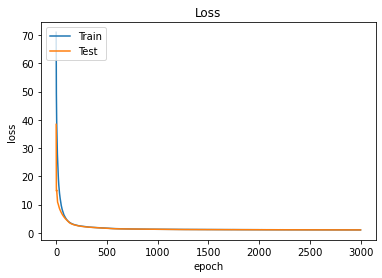

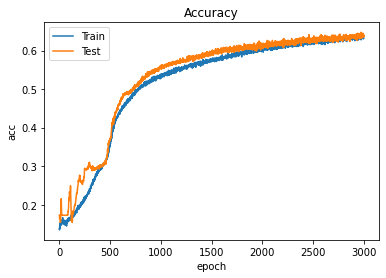

In [21]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### RESULTS

In [23]:
from sklearn.metrics import classification_report

predictions = model.predict_classes(x_testcnn)
y_test = y_test.astype(int)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       221
           1       0.50      0.55      0.52       188
           2       0.67      0.44      0.53       216
           3       0.65      0.62      0.64       222
           4       0.59      0.60      0.59       175
           5       0.60      0.75      0.67       213
           6       0.85      0.91      0.88        45

    accuracy                           0.64      1280
   macro avg       0.66      0.67      0.66      1280
weighted avg       0.64      0.64      0.63      1280



In [24]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predictions)
print (matrix)

[[174  14   4  23   4   2   0]
 [ 12 103   8  15  21  26   3]
 [ 16  16  96  21  13  54   0]
 [ 24  27  19 138  10   2   2]
 [  1  32   8   8 105  21   0]
 [  1  11   8   7  25 159   2]
 [  1   2   0   0   0   1  41]]


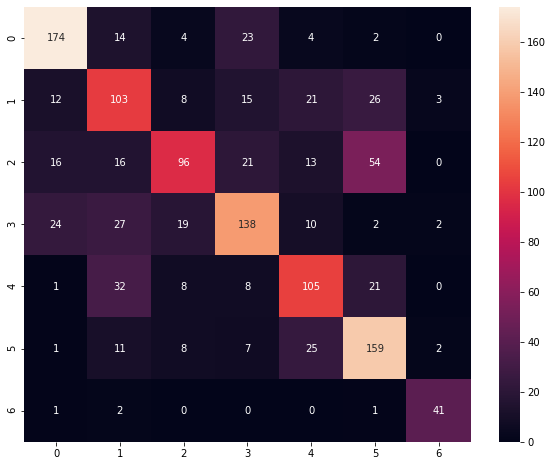

In [25]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d");

In [32]:
#comando para salvar el modelo:

model_name = 'EmotionClassificationModel.h5'
save_dir = '/kaggle/working'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working\EmotionClassificationModel.h5 
